<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 
В вашем распоряжении набор фотографий людей с указанием возраста.

## Описание данных

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). 

Оригинальный датасет разбит на тестовый, тренировочный и валидационный.    
В нашем распоряжении одна папка со всеми изображениями `/datasets/faces/final_files` и csv-файл labels.csv с метками, который содержит две колонки: 
- `file_name` - имя файла изображения
- `real_age` - возраст человека на фотографии.

В оригинальном датасете представлены разнообразные изображения с фотографиями людей во весь рост, портретные фотографии. Для каждого изображения авторы также предоставляют соответствующее изображение, которое содержит только изображения лица, вырезанное из исходного изображения, правильно ориентированное (повернутое) с 40% отступом, полученное с помощью детектора лиц [Mathias et. al](http://markusmathias.bitbucket.org/2014_eccv_face_detection/).  

В нашем распоряжении уже обработанный датасет с лицами, таким образом, задачу детекции лиц производить не нужно.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import numpy as np

img_path = '/datasets/faces/final_files/'

Изучим датасет. 

Построим график распределения возраста в выборке.  
Посмотрим на неколько случайно взятых изображений.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_it = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Видим количество найденных изображений

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


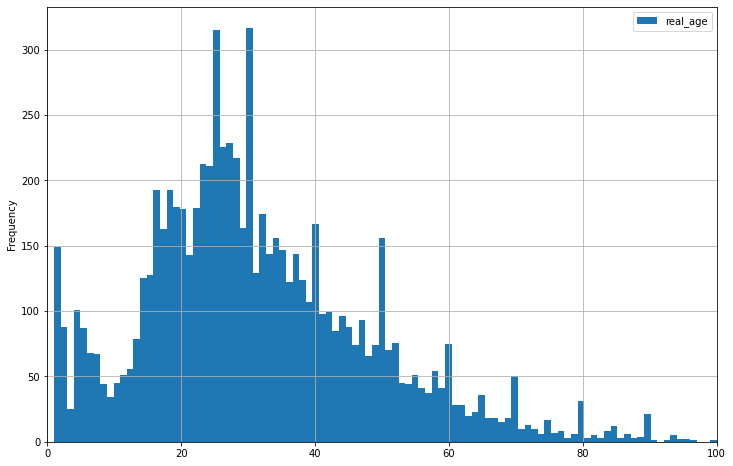

In [3]:
labels.plot(kind='hist', bins=100, figsize=(12,8), grid=True, xlim=(0,100))
labels.describe().T

Количество изображений и меток совпадает.

- В основном значения возраста распредлены нормально.  
- Максимум приходится на значение возраста около 27, однако также имеется небольшой максимум в значениях возраста до 10 лет. 
- Позле значения 20 выбиваются частоты значений возраста, кратные 10, возможно это свзяано с округлениями значений возраста до 10 лет в случае, если возраст человека на фото не был известен точно.

Изобразим случайные 15 изображений, к каждой картинке добавим значение целевого признака

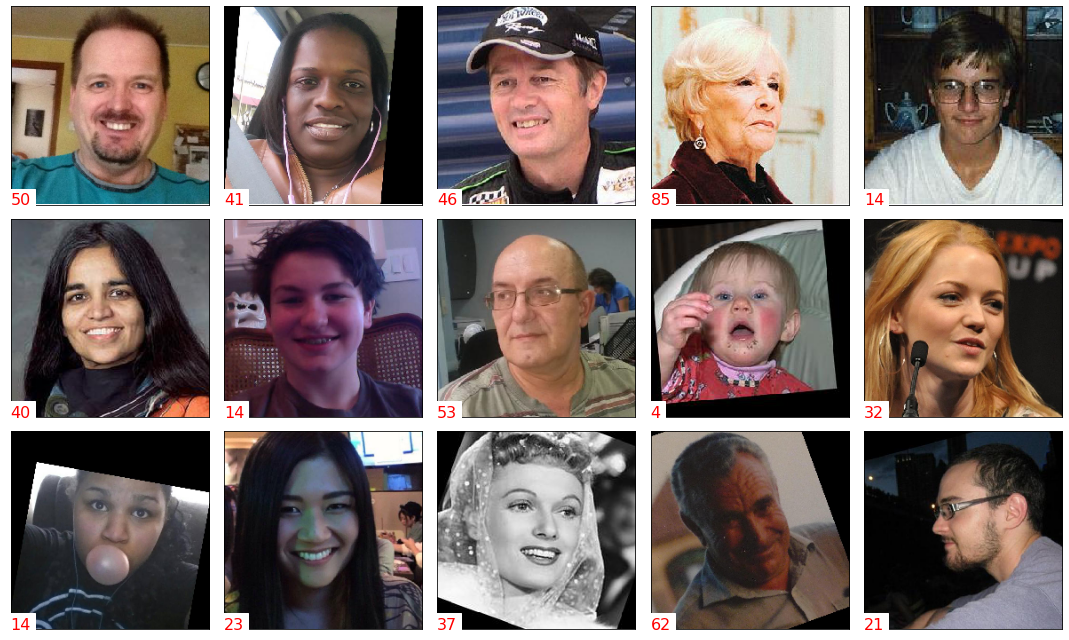

In [4]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Попавшие в вывод изображения - квадратные. На всех изображены только лица людей, расположенные в центре.  
Таким образом работаем с фотографиями, полученными уже после детекции. 

Посмотрим на размеры изображений

In [5]:
img_sizes = labels.copy().set_index('file_name')
for file_name in tqdm(labels.file_name):
    img = Image.open(img_path+file_name)
    img_sizes.loc[file_name, ['h','w']] = img.size

img_sizes.sample(10)

  0%|          | 0/7591 [00:00<?, ?it/s]

,real_age,h,w
file_name,,,
006120.jpg,45,178.0,178.0
006650.jpg,30,119.0,120.0
001218.jpg,30,202.0,201.0
001913.jpg,24,689.0,689.0
005108.jpg,32,434.0,434.0
007386.jpg,50,111.0,111.0
005167.jpg,38,239.0,239.0
003586.jpg,70,379.0,379.0
005397.jpg,19,131.0,131.0


Изображения имеют разное разрешение. Это не проблема, поскольку метод-итератор класса `ImageDataGenerator` приведёт их к одинаковому. Мы будем использовать размер `(224, 224)`, который задан по умолчанию для модели `ResNet50`

Посмотрим, сколько изображений имеют неравное соотношение сторон

In [6]:
img_sizes['is_square'] = (img_sizes.h - img_sizes.w) <= 1
(~img_sizes.is_square).sum()

117

Выведем случайные 15 таких изображений

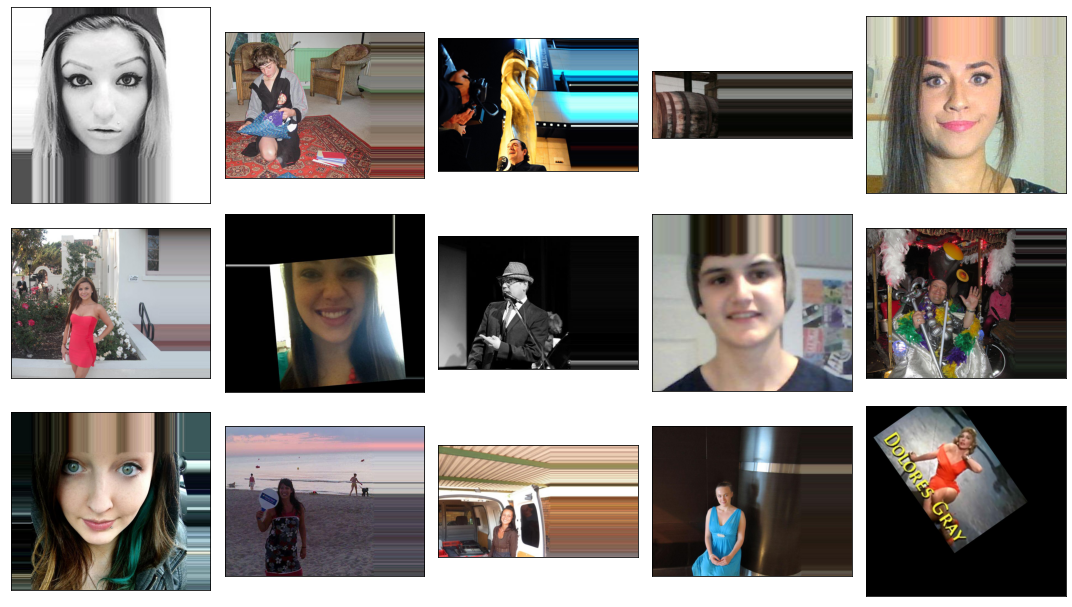

In [7]:
fig = plt.figure(figsize=(15,9))
i = 0
for file_name in img_sizes[~img_sizes.is_square].sample(15).index:
    i += 1
    fig.add_subplot(3, 5, i)
    plt.imshow(Image.open(img_path+file_name))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выявили наличие проблем в датасете. А именно, некторые фотографии
- *не квадратные*

Наличие таких фотографий может быть связано с ошибками в процессе сохранения изображений.  
При загрузке таких изображений метод-итератор класса `ImageDataGenerator` приведёт их к квадратным, тем самым исказив. Однако доля таких изображений невилика.

Также имеются изображения с:
- *не портретными фотографиями* - люди во весь рост, сразу несколько человек и т.п.
- *не содержат лиц или людей* вовсе.

Это вероятнее всего связано с ошибками работы алгоритма детекции.

Наличие таких проблемных изображений в обучающей выборке приведёт к тому, что обученная модель будет склонна ошибаться.

## Обучение модели

Код обучения выполнялся на GPU на отдельном сервере. Сервер импортирует и выполняет следующие функции:

- `load_train(path)` - загрузка тренировочного датасета,
- `load_test(path)` - загрузка тестового датасета,
- `create_model(input_shape)` - создание архитектуры сети, компиляция модели,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - обучение модели

В папке *path* содержится csv-файл *labels.csv* с названиями файлов `file_name` и целевой меткой `real_age` и папка с изображениями `/final_files`

- Весь датасет был разбит на тренировочный и тестовый в соотношении 3 : 1
- Была выбрана предобученная 50-слойная модель **ResNet50** с весами *resnet50_weights_tf_dim_ordering_tf_kernels_notop* для сети без полносвзняого слоя по умолчанию.  
- Последний полносвязный слой был заменён на слой с одним нейроном, с функцией активации `"relu"`, поскольку мы решаем задачу регрессии.
- Также были установлены:
    - Алгоритм оптимизации *Adam* со скоростью обучения = 0.0005, 
    - Функция потерь - *Mean squared error*
    - Метрика - *Mean absolute error*
- Количество эпох обучения = 20

Далее приводится код, который импортируется для запуска на сервере. 

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):
    """ Loading of train dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    """ Loading of test dataset from 'final_files/' subfolder in `path`
    """
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    """ Creating of ResNet50 model for objects with shape = `input_shape`.  
        Custom fully-connected layer at the top of the network 
        with `relu` activation for predicting of age value
    """
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """ Training of `model`
    
    ----
    `train_data` : DataFrameIterator for training dataset
    `test_data` : DataFrameIterator for validation dataset
    `epochs`, `batch_size` : params of keras.Model.fit()
    """
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model
```

**Результат обучения**:

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 95s - loss: 211.8521 - mean_absolute_error: 10.9111 - val_loss: 379.6609 - val_mean_absolute_error: 14.4465
Epoch 2/20
178/178 - 88s - loss: 130.1674 - mean_absolute_error: 8.7135 - val_loss: 365.8682 - val_mean_absolute_error: 14.1413
Epoch 3/20
178/178 - 88s - loss: 115.3948 - mean_absolute_error: 8.1242 - val_loss: 358.0574 - val_mean_absolute_error: 13.9314
Epoch 4/20
178/178 - 87s - loss: 102.7762 - mean_absolute_error: 7.6883 - val_loss: 223.0560 - val_mean_absolute_error: 11.1206
Epoch 5/20
178/178 - 88s - loss: 88.3081 - mean_absolute_error: 7.0859 - val_loss: 114.2715 - val_mean_absolute_error: 8.1138
Epoch 6/20
178/178 - 88s - loss: 81.7627 - mean_absolute_error: 6.8652 - val_loss: 99.1921 - val_mean_absolute_error: 7.7625
Epoch 7/20
178/178 - 87s - loss: 74.9508 - mean_absolute_error: 6.5632 - val_loss: 121.9875 - val_mean_absolute_error: 8.1475
Epoch 8/20
178/178 - 88s - loss: 66.9505 - mean_absolute_error: 6.2037 - val_loss: 120.8005 - val_mean_absolute_error: 8.5310
Epoch 9/20
178/178 - 88s - loss: 75.1310 - mean_absolute_error: 6.5610 - val_loss: 176.6617 - val_mean_absolute_error: 9.5800
Epoch 10/20
178/178 - 88s - loss: 71.1200 - mean_absolute_error: 6.3748 - val_loss: 198.0490 - val_mean_absolute_error: 11.0104
Epoch 11/20
178/178 - 88s - loss: 65.3967 - mean_absolute_error: 6.1037 - val_loss: 91.4429 - val_mean_absolute_error: 7.0879
Epoch 12/20
178/178 - 87s - loss: 58.8317 - mean_absolute_error: 5.8296 - val_loss: 77.7937 - val_mean_absolute_error: 6.5849
Epoch 13/20
178/178 - 88s - loss: 52.3998 - mean_absolute_error: 5.5118 - val_loss: 92.1339 - val_mean_absolute_error: 7.4092
Epoch 14/20
178/178 - 88s - loss: 56.6518 - mean_absolute_error: 5.7279 - val_loss: 160.2033 - val_mean_absolute_error: 9.2474
Epoch 15/20
178/178 - 88s - loss: 58.4976 - mean_absolute_error: 5.8131 - val_loss: 86.5187 - val_mean_absolute_error: 6.8734
Epoch 16/20
178/178 - 87s - loss: 50.7665 - mean_absolute_error: 5.4375 - val_loss: 96.2201 - val_mean_absolute_error: 7.1796
Epoch 17/20
178/178 - 88s - loss: 44.3891 - mean_absolute_error: 5.0769 - val_loss: 92.5910 - val_mean_absolute_error: 6.9648
Epoch 18/20
178/178 - 88s - loss: 42.1654 - mean_absolute_error: 4.9461 - val_loss: 118.7542 - val_mean_absolute_error: 8.1867
Epoch 19/20
178/178 - 87s - loss: 42.2952 - mean_absolute_error: 4.9740 - val_loss: 86.2794 - val_mean_absolute_error: 7.0360
Epoch 20/20
178/178 - 88s - loss: 41.2668 - mean_absolute_error: 4.9012 - val_loss: 83.8178 - val_mean_absolute_error: 6.7046

60/60 - 9s - loss: 83.8178 - mean_absolute_error: 6.7046
Test MAE: 6.7046

```

## Анализ обученной модели

Модель достигла значения `MAE = 6.705` за 20 эпох.

В среднем модель ошибается примерно на 7 лет при предсказании возраста на тестовой выборке и на 5 на тренировочной.
Модель переобучилась.

Можно улучшить качество предсказаний модели, если:
- Обучать модель на большем количестве циклов обучения
- Избавиться от ошибок в детекции лиц в изображениях датасета.

Требуемое значение метрики `MAE < 8` получено